In [1]:
from opty import Problem, create_objective_function, parse_free
import sympy as sp
import numpy as np
import scipy as sc
import time
import pickle
import sympy.physics.mechanics as me
import sys
sys.path.insert(0, "..")
from importlib import reload

In [2]:
import equations as eq
reload (eq);
model_struct = sc.io.loadmat('../das3_eul_abd.mat')
data_struct = sc.io.loadmat('../data_model.mat')
initPos = 'InitPosOptQuat'
start = time.time()
# eq.create_eoms_eul(model_struct,data_struct,initPos,derive = 'symbolic',gen_matlab_functions = 1)
MM,FO,TE,TE_conoid,q,u,fr,frstar,kindeq,xdot,activations = eq.create_eoms_eul(model_struct,data_struct,initPos,derive = 'numeric',gen_matlab_functions = 0)
time_to_create = time.time() - start

TE created
equations created


In [19]:
import equations as eq
reload (eq);
data_struct = sc.io.loadmat('../data_model.mat')
dict_vals,symlist, value_list = eq.create_parameters_dict(data_struct, initPos)
x0 = data_struct['params'][initPos][0,0]['initCondEul'].item()
x0t = list(x0.T[0])

In [20]:
eoms_implicit = sp.Matrix(kindeq).col_join(fr+frstar+TE)

In [21]:
import trajectory_lib as tr
reload (tr);
num_nodes = 51
file = '../Motion/abduciton/abd_struct.mat'
traj, interval_value, time, _ = tr.exp_trajectory_eul(file,num_nodes)

In [22]:
state_symbols = tuple(q+u)
num_states = len(state_symbols)
specified_symbols = tuple(activations)
num_inputs = len(specified_symbols)
t = me.dynamicsymbols._t

In [23]:
def obj(free):
    min_traj = 200 * interval_value * np.sum((traj - free[:10*num_nodes])**2)
    min_vel = 5 * interval_value * np.sum((free[10*num_nodes:num_states*num_nodes])**2)
    min_torque = 1 * interval_value * np.sum(free[num_states*num_nodes:(num_states + num_inputs)*num_nodes]**2)
    return min_traj + min_torque + min_vel

def obj_grad(free):
    grad = np.zeros_like(free)
    grad[:10*num_nodes] = 200 * 2.0 * interval_value * (free[:10*num_nodes] - traj)
    grad[10*num_nodes:num_states*num_nodes] = 5 * 2 * interval_value * free[10*num_nodes:num_states*num_nodes]
    grad[num_states*num_nodes:(num_states + num_inputs)*num_nodes] = 1 * 2.0 * interval_value * free[num_states*num_nodes:(num_states + num_inputs)*num_nodes]
    return grad

In [24]:
instance_constraints = []
for i in range(10):
    instance_constraints.append(state_symbols[i].func(0.0)-x0t[i])

# instance_constraints.append(state_symbols[9].func(0.0)-x0t[9])
# instance_constraints.append(state_symbols[8].func(0.0)-x0t[8])
# instance_constraints.append(state_symbols[7].func(0.0)-x0t[7])
# instance_constraints.append(state_symbols[6].func(0.0)-x0t[6])

    

# # bounds = (-3,3)*len(w)
# # bndrs = dict(zip(w,bounds))
bounds1 = (0.0,1)
bounds = (bounds1,)*len(activations)
bndrs = dict(zip(activations,bounds))

In [25]:
prob = Problem(obj, obj_grad, eoms_implicit, state_symbols,
               num_nodes, interval_value,
               known_parameter_map={},
               instance_constraints=instance_constraints,
               bounds=bndrs,
               integration_method='midpoint'
) #               


In [26]:
# feas_tol = 1e-5
prob.add_option('max_iter',10000)
# prob.add_option('acceptable_tol', feas_tol)
# prob.add_option('tol', feas_tol)
# prob.add_option('constr_viol_tol', feas_tol)
# prob.add_option('bound_frac', 0.001)
# prob.add_option('mu_strategy', 'adaptive')
prob.add_option('limited_memory_max_history', 40)
# prob.add_option('acceptable_constr_viol_tol', feas_tol)
# prob.add_option('nlp_scaling_method', 'None')

In [27]:
initial_guess = np.zeros(prob.num_free)
initial_guess[:10*num_nodes] = traj

In [28]:
solution, info = prob.solve(initial_guess)
print(info['status_msg'])
print(info['obj_val'])

b'Algorithm terminated successfully at a locally optimal point, satisfying the convergence tolerances (can be specified by options).'
7.039693312522465


23.443794384297064


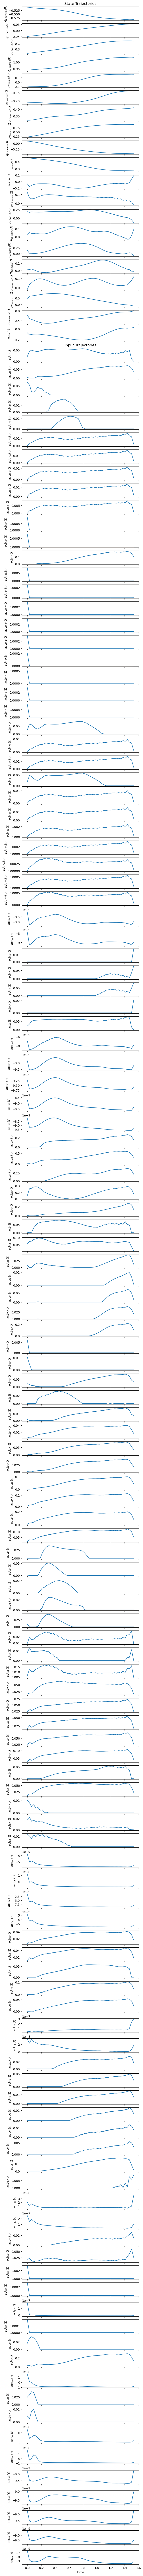

In [29]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(int(num_states+num_inputs), 1, sharex=True,
                         figsize=(6.4, 0.8*(num_states+num_inputs)),
                         layout='compressed')
prob.plot_trajectories(solution, axes=axes)

act_obj = np.sum(solution[num_states*num_nodes:(num_states + num_inputs)*num_nodes]**2)
print(act_obj)

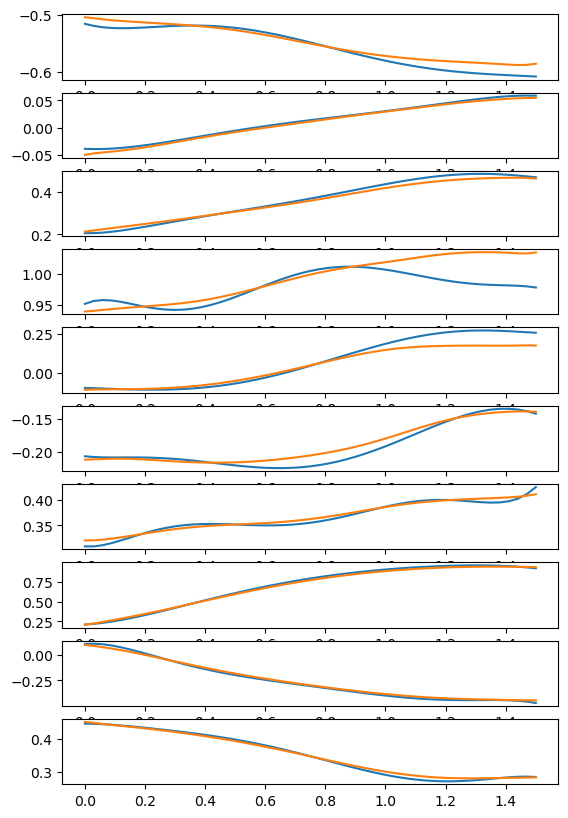

In [30]:
fig, axs = plt.subplots(10)
for j in range(10):
    axs[j].plot(time,traj[j*num_nodes:(j+1)*num_nodes])
    axs[j].plot(time,solution[j*num_nodes:(j+1)*num_nodes])
    fig.set_figheight(10)

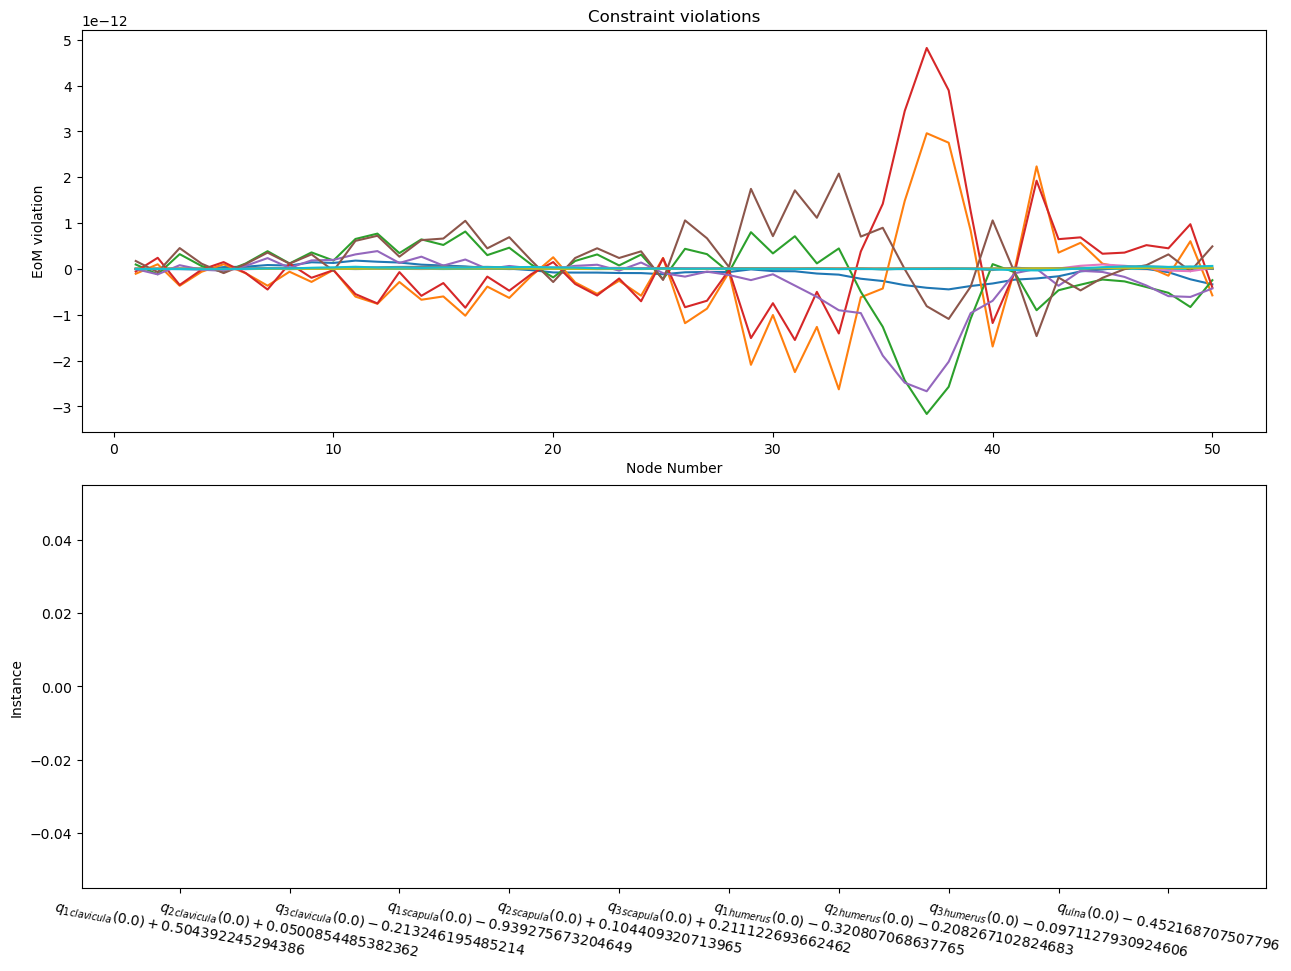

In [31]:
fig, axes = plt.subplots(2, figsize=(12.8, 9.6),
                         layout='constrained')
prob.plot_constraint_violations(solution, axes=axes)

In [16]:
# import equations as eq
# reload (eq);

# sol = eq.sol2mot_quat(solution, num_nodes, len(q), time)


In [18]:
import trajectory_lib as tr
reload (tr);
file_name = '../eul_abd_eulIC.mat'
tr.quat2matfile(solution,activations,len(q),num_states,num_nodes,time,file_name)

Saved to .mat file
